In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(sys.path[0])))

import matplotlib.pyplot as plt
import numpy as np
import umap
import pandas as pd
from datasets import Dataset
import seaborn as sns
import json
import altair as alt

from src.paths import get_project_root, outputp
# from src.reporting import extract_orders_from_sns

sns.set_style("whitegrid")

from tqdm.notebook import tqdm
tqdm.pandas()

import wandb
from dotenv import load_dotenv
load_dotenv()

True

## Load data

In [2]:
wandb.login() # relies on WANDB_API_KEY env var
run = wandb.init(
    project="ea-forum-analysis", job_type="visualization", dir=get_project_root()
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vpetukhov. Use `wandb login --relogin` to force relogin
wandb: ERROR Failed to sample metric: Not Supported


In [3]:
art = run.use_artifact("sbert_emb_data:all-mpnet-base-v2")
art.download()
dv_data = pd.read_pickle(art.file())
# data = pd.read_pickle(datap("sbert_emb_data.pkl"))
posts = Dataset.load_from_disk(run.use_artifact("posts_raw:latest").download()).to_pandas()
posts = posts.set_index('pageUrl').loc[dv_data['art_df'].pageUrl].reset_index().set_index('_id')

comments = Dataset.load_from_disk(run.use_artifact("comments_raw:latest").download()).to_pandas().set_index('_id')
users = Dataset.load_from_disk(run.use_artifact("users_raw:latest").download()).to_pandas().set_index('_id')

wandb: Downloading large artifact sbert_emb_data:all-mpnet-base-v2, 76.42MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.1
wandb: Downloading large artifact posts_raw:latest, 272.30MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.0
wandb: Downloading large artifact comments_raw:latest, 209.93MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.0
wandb: ERROR Failed to serialize metric: division by zero
wandb:   3 of 3 files downloaded.  


In [4]:
posts = posts[posts.userId.isin(users.index)]
comments = comments[comments.userId.isin(users.index)]
comments = comments[comments.postId.isin(posts.index)]

In [5]:
n_posts_per_tag = posts.tags.explode().dropna().value_counts()
sum(n_posts_per_tag >= 30)

232

## Segment users

### Extract features

In [7]:
from src.parsing import estimate_posts_per_user, estimate_comments_per_user
from pandas import DataFrame, Series
from datetime import datetime

In [8]:
users['posts'] = estimate_posts_per_user(posts, users.index)
users['comments'] = estimate_comments_per_user(comments, users.index)

In [9]:
user_info = DataFrame(dict(
    karma = users['karma'].fillna(0),
    n_posts = users['posts'].map(len),
    n_comments = users['comments'].map(len),
    lifespan = datetime.now().date() - users['createdAt'].map(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ').date()),
    category = ''
))

user_info['n_days'] = user_info['lifespan'].map(lambda x: x.days)

for c in ['n_posts', 'n_comments']:
    user_info[c + '_norm'] = user_info[c] / (user_info.n_days / 365)

user_info['question_frac'] = users['posts'].map(lambda ps: None if len(ps) == 0 else posts.question[ps].mean())
user_info['bio_filled'] = (users.bio != '')

In [10]:
post_score_cols = [f'post_score_{k}' for k in ['lq', 'med', 'uq']]
user_info[post_score_cols] = np.concatenate(users['posts'].map(
    lambda ps: np.atleast_2d(np.array([None, None, None]) if len(ps) == 0 else np.quantile(posts.baseScore[ps].values, [0.25, 0.5, 0.75]))
).values, axis=0)

com_score_cols = [f'comment_score_{k}' for k in ['lq', 'med', 'uq']]
user_info[com_score_cols] = np.concatenate(users['comments'].map(
    lambda cs: np.atleast_2d(np.array([None, None, None]) if len(cs) == 0 else np.quantile(comments.baseScore[cs].values, [0.25, 0.5, 0.75]))
).values, axis=0)

In [11]:
p_df = user_info[['karma', 'n_posts_norm', 'n_comments_norm', 'question_frac', 'bio_filled'] + post_score_cols + com_score_cols].fillna(0).copy()
p_df = p_df[(user_info.n_posts > 0) & (user_info.n_comments > 0)]

for c in ['karma'] + post_score_cols + com_score_cols:
    p_df[c] = np.log(p_df[c].abs() + 1) * np.sign(p_df[c])
for c in ['n_posts_norm', 'n_comments_norm'] :
    p_df[c] = np.log(p_df[c] + 1)

print(p_df.shape[0])

2118


### Cluster users

This analysis doesn't show anything interesting, so it's not included to the report

In [9]:
from sklearn.preprocessing import minmax_scale

In [10]:
p_df_scaled = DataFrame(minmax_scale(p_df.values), columns=p_df.columns, index=p_df.index)

2139


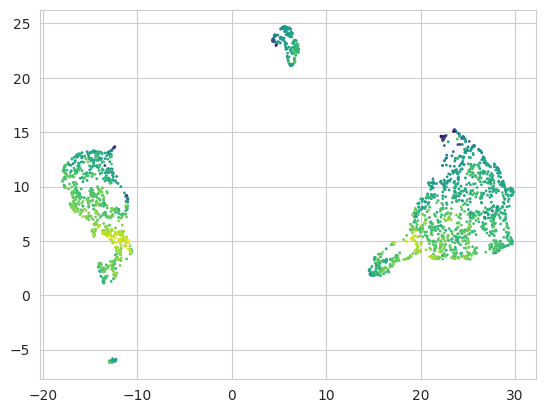

In [11]:
emb = umap.UMAP(spread=2, min_dist=0.1, n_epochs=2000).fit_transform(p_df_scaled)
plt.scatter(emb[:,0], emb[:,1], s=1, c=p_df['karma'], cmap='viridis')

### Visualize user groups

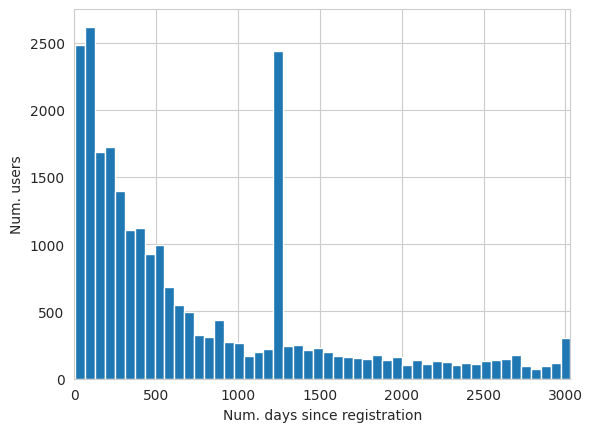

In [12]:
user_info.n_days.hist(bins=50)
plt.xlabel('Num. days since registration'); plt.ylabel('Num. users');
plt.xlim(0, user_info.n_days.max());

In [13]:
user_info['category'] = ''
user_info.loc[((user_info.n_posts == 0) & (user_info.n_comments == 0)), 'category'] = 'inactive'

low_act_mask = (
    (
        ((user_info.n_posts <= 3) & (user_info.n_comments <= 5))
        # (np.minimum(user_info.n_posts, user_info.n_comments) < 2)
    ) & 
    (user_info.category == '')
)
user_info.loc[low_act_mask, 'category'] = 'low-activity'
user_info.loc[(user_info.n_posts >= 70), 'category'] = 'top-writers'
user_info.loc[(user_info.karma < 0), 'category'] = 'down-voted'
user_info.loc[user_info.category == '', 'category'] = 'active'
user_info.loc[(user_info.category == 'active') & (user_info.n_comments < 2) & (user_info.n_posts > 10), 'category'] = 'posters'
user_info.loc[(user_info.category == 'active') & (user_info.n_posts < 2), 'category'] = 'commenters'

In [14]:
users.loc[user_info.index[user_info.category == 'posters']].username

_id
fp3nBS8Fjapnt8nmp                Open Philanthropy
kPucqpaq7QyPczK5W                  Group Organizer
qQxiv6F5dRX97vkPN                    Dan Hendrycks
Bvbm6zQXZ6s6t3H5f                    EA Fellowship
QzSZfxXnSFvSuCPRh                EA Forum Archives
syx2QxGnDXhsr9tRi    Centre for Effective Altruism
Fk8Gi5q4eX8gT8z4R                     givedirectly
PsWav4hR6PdJbGghp                       AI Impacts
NeQgifeag8Lg5GT5r                     Introduction
Name: username, dtype: object

In [15]:
users.loc[user_info.index[user_info.category == 'top-writers']].username

_id
tKxXWdBF6mbkSpEFx                          evelynciara
RCd6bMJxLwK29NWFH                               nathan
RvR6DrvuoXK6bSm67                             MichaelA
cjaRSePyvkZYSRSNe    The Centre for Effective Altruism
YRCdk7cvPT6pyiph9                          NunoSempere
YakMuM4sRNSmaY7E8                          80000_Hours
zr95vzsKSXS9yT7wS                        Milan_Griffes
9Fg4woeMPHoGa6kDA                      HoldenKarnofsky
jd3Bs7YAT2KqnLxYD                         aarongertler
LwDSW3qxheugptwRg                        Peter_Hurford
oyGM4Jhj8WExFnCkG                            RyanCarey
Name: username, dtype: object

In [16]:
n_users_per_segment = user_info.category.value_counts()
n_users_per_segment

inactive        18637
low-activity     3789
active            992
down-voted        836
commenters        629
top-writers        11
posters             9
Name: category, dtype: int64

In [17]:
user_info_filt = user_info[user_info.category.isin(['low-activity', 'active', 'commenters'])].copy()
user_info_filt.shape[0]

5410

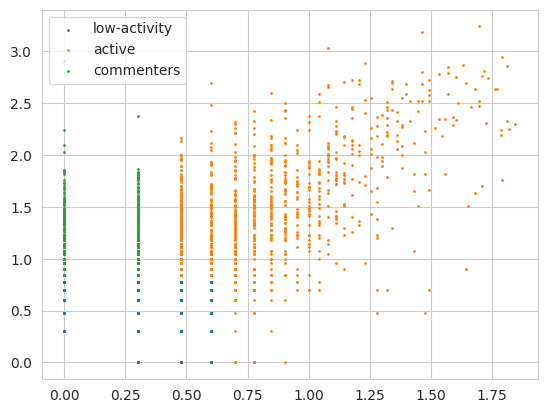

In [18]:
for c in user_info_filt.category.unique():
    mask = user_info_filt.category == c
    plt.scatter(
        np.log10(user_info_filt.n_posts[mask] + 1), 
        np.log10(user_info_filt.n_comments[mask] + 1), 
        label=c, 
        s=1
        # s=np.log10(user_info_filt.karma[mask] + 1)
    )
plt.legend()

In [19]:
js_df = user_info_filt[['karma', 'n_posts', 'n_comments', 'n_posts_norm', 'n_comments_norm', 'post_score_med', 'comment_score_med', 'category']].\
    join(users[['username', 'pageUrl']]).join(user_info_filt[['lifespan']].applymap(lambda x: x.days))

ui_dicts = js_df.drop(columns=['n_posts_norm', 'n_comments_norm']).\
    groupby('category').apply(lambda x: [x]).map(lambda x: x[0]).\
    map(lambda df: df.to_dict('list'))

new_vs_old_dicts = {
    k: js_df[['n_posts_norm', 'n_comments_norm']][(js_df.lifespan >= lmin) & (js_df.lifespan < lmax)].to_dict('list')
    for (k,lmin,lmax) in [('3-9 months', 90, 270), ('1-3 years', 365, 365 * 3), ('>3 years', 365 * 3, 1e5)]
}

user_info_json = {
    'segments': {
        'n_users': list(map(int, n_users_per_segment)),
        'segments': list(n_users_per_segment.index)
    },
    'info': dict(ui_dicts),
    'new_vs_old': new_vs_old_dicts
}

with open(outputp('data/user_info.json'), 'w') as f:
    json.dump(user_info_json, f)

## Map users to tags

In [55]:
from src.parsing import estimate_tag_scores_per_user, estimate_relevant_posts_per_user
from sklearn.cluster import AgglomerativeClustering
from src.reporting import get_heatmap_json

def embed_tags_umap(tags_per_user, spread=2, min_dist=0.1, n_epochs=2000, metric='cosine'):
    p_mat = tags_per_user
    p_mat = (p_mat.T / p_mat.sum(axis=1)).T
    return umap.UMAP(metric=metric, spread=spread, min_dist=min_dist, n_epochs=n_epochs).fit_transform(p_mat.values)


def plot_clustered_embedding(emb, clusts, s=10):
    for c in np.unique(clusts):
        plt.scatter(emb[clusts==c,0], emb[clusts==c,1], label=c, s=s)
    plt.legend()


def split_df_by_factor(df, factor):
    return df.groupby(factor).apply(lambda x: [x]).map(lambda x: x[0])


def get_clustered_embedding_json(embedding, clusters):
    return {
        k: [[round(v, 3) for v in vs] for _,vs in vals.reset_index().iterrows()]
        for k, vals in split_df_by_factor(DataFrame(embedding, columns=['x', 'y']), clusters).items()
    }

In [34]:
relevant_post_scores_per_user = estimate_relevant_posts_per_user(comments, posts)

### Tags

In [ ]:
tags_per_user = estimate_tag_scores_per_user(
    relevant_post_scores_per_user[user_info.category[relevant_post_scores_per_user.index] == 'active'], 
    posts.tags, min_content_per_user=10, min_users_per_tag=10,
    tag_filter=n_posts_per_tag.index[n_posts_per_tag >= 50]
)

tags_per_user.shape

(987, 141)

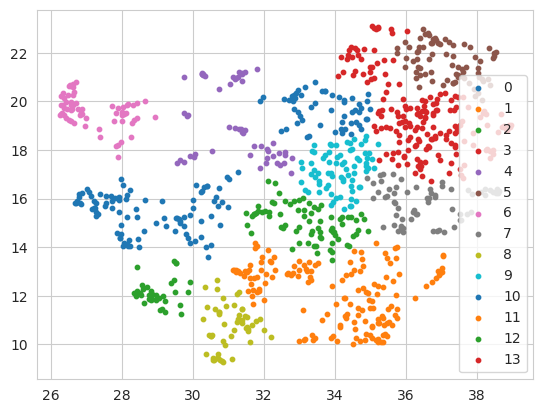

In [22]:
emb_users = embed_tags_umap(tags_per_user)
clusts_users = AgglomerativeClustering(n_clusters=14, affinity='euclidean', linkage='ward').fit_predict(emb_users)
plot_clustered_embedding(emb_users, clusts_users)

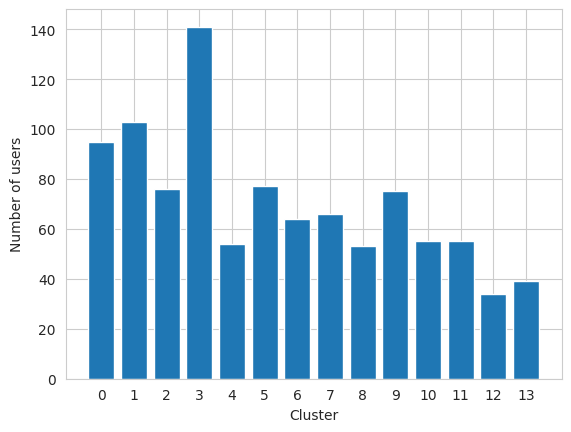

In [23]:
n_users_per_clust = pd.value_counts(clusts_users).sort_index()
plt.bar(n_users_per_clust.index, n_users_per_clust.values)
plt.xlabel('Cluster'); plt.ylabel('Number of users');
plt.xticks(n_users_per_clust.index);

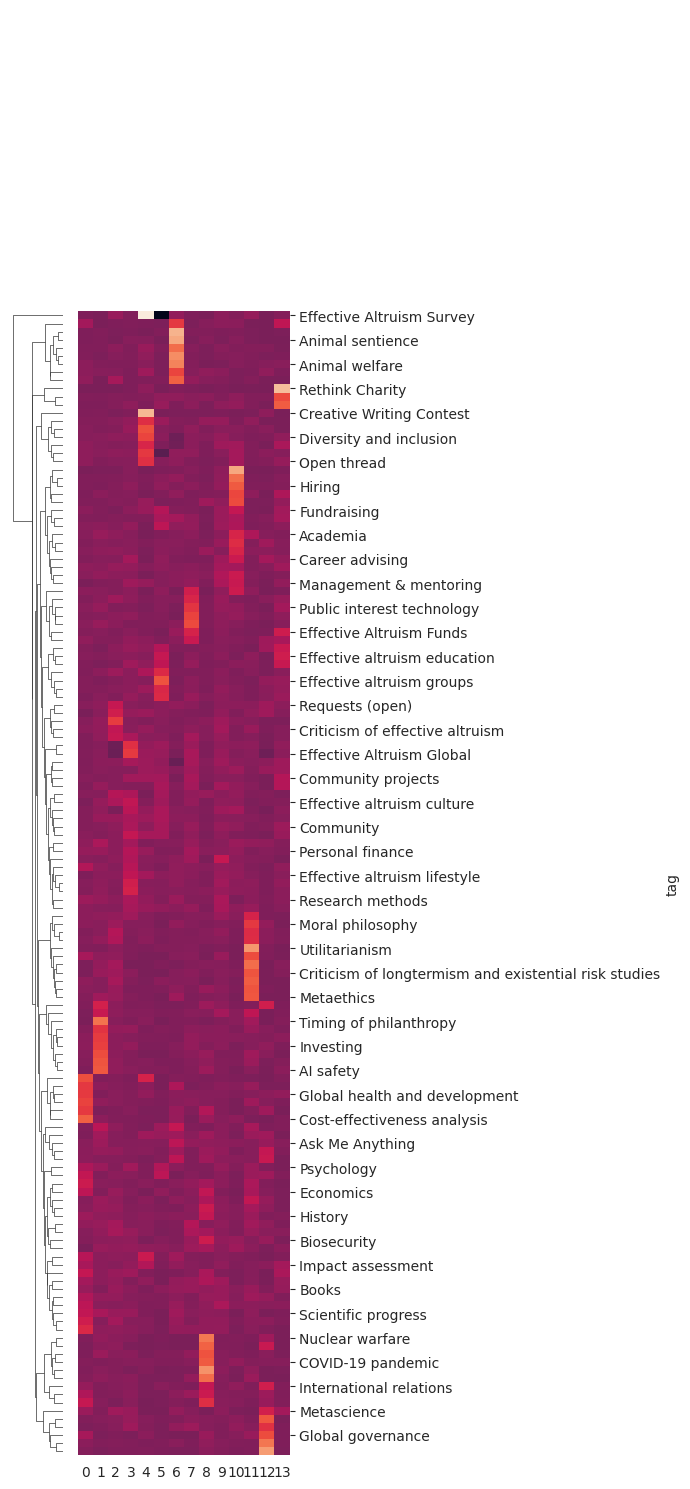

In [24]:
p_mat_agg = (tags_per_user.T / tags_per_user.sum(axis=1)).T.groupby(clusts_users).mean()
p_mat_agg = (p_mat_agg / p_mat_agg.sum()).T
cmap = sns.clustermap(
    p_mat_agg, figsize=(7,15), cbar_pos=None, #method='ward',
    col_cluster=False, metric='cityblock'
);
plt.tight_layout()
cmap

In [26]:
emb_tags = umap.UMAP(spread=2, min_dist=1, n_epochs=2000).fit_transform(p_mat_agg.values)

In [27]:
top_clust_per_tag = p_mat_agg.T.idxmax()
top_clust_per_tag[p_mat_agg.T.max() < 0.3] = -1

In [28]:
tag_info = dict(
    n_posts = list(map(int, n_posts_per_tag[top_clust_per_tag.index])),
    tag = list(top_clust_per_tag.index)
)

In [33]:
hm_dict, tag_levels, clust_levels = get_heatmap_json(p_mat_agg.iloc[cmap.dendrogram_row.reordered_ind, :], col_names=['tag', 'cluster', 'score'])

user_embedding = get_clustered_embedding_json(emb_users, clusts_users)
tag_embedding = get_clustered_embedding_json(emb_tags, top_clust_per_tag.values)

top_tags_per_clust = p_mat_agg.T.apply(lambda x: ", ".join(x.sort_values(ascending=False).index[:5]), axis=1)
user_info_json = users.loc[tags_per_user.index, ['username', 'karma', 'pageUrl']].\
    join(user_info[['n_posts', 'n_comments']]).reset_index(drop=True).to_dict('list')

user_tag_matching_json = {
    'tag_heatmap': {
        'scores': hm_dict,
        'tag_levels': tag_levels,
        'clust_levels': clust_levels
    },
    'user_embedding': user_embedding,
    'tag_embedding': tag_embedding,
    'tag_info': tag_info,
    'top_tags_per_clust': top_tags_per_clust.to_dict(),
    'user_info': user_info_json,
    'n_users_per_clust': list(n_users_per_clust)
}

with open(outputp('data/user_tag_matching.json'), 'w') as f:
    json.dump(user_tag_matching_json, f)

### Semantic clusters

In [48]:
dv_data['art_df'].index = posts.reset_index().set_index('pageUrl').reindex(dv_data['art_df'].pageUrl)['_id'].values

In [52]:
dv_clusts_per_user = estimate_tag_scores_per_user(
    relevant_post_scores_per_user[user_info.category[relevant_post_scores_per_user.index] == 'active'], 
    dv_data['art_df'].clust1.map(lambda x: [x]), min_content_per_user=10
)

dv_clusts_per_user.shape

(987, 15)

In [87]:
user_specificity_to_dv_clusts = (dv_clusts_per_user.T / dv_clusts_per_user.T.sum()).T
user_specificity_to_dv_clusts = user_specificity_to_dv_clusts.iloc[:,user_specificity_to_dv_clusts.columns.map(lambda x: int(x.split('.')[0])).argsort()]

<AxesSubplot: xlabel='tag', ylabel='tag'>

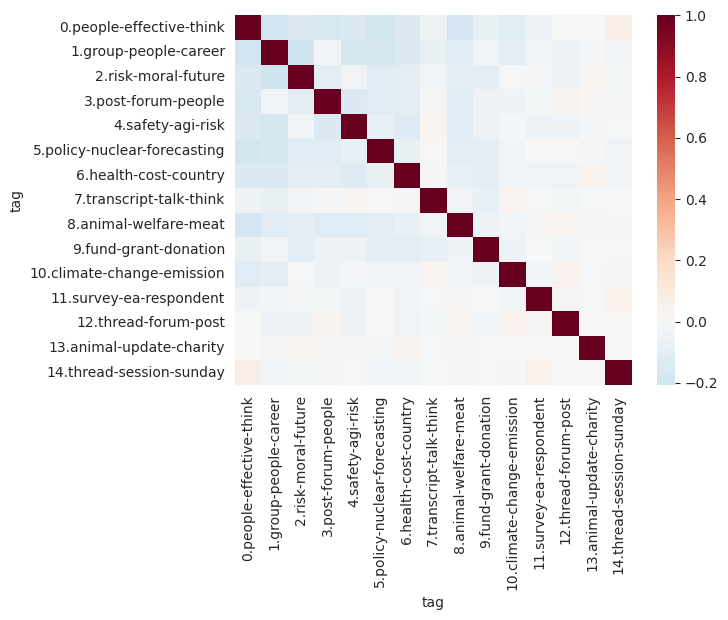

In [96]:
sns.heatmap(user_specificity_to_dv_clusts.corr(), cmap='RdBu_r', center=0)

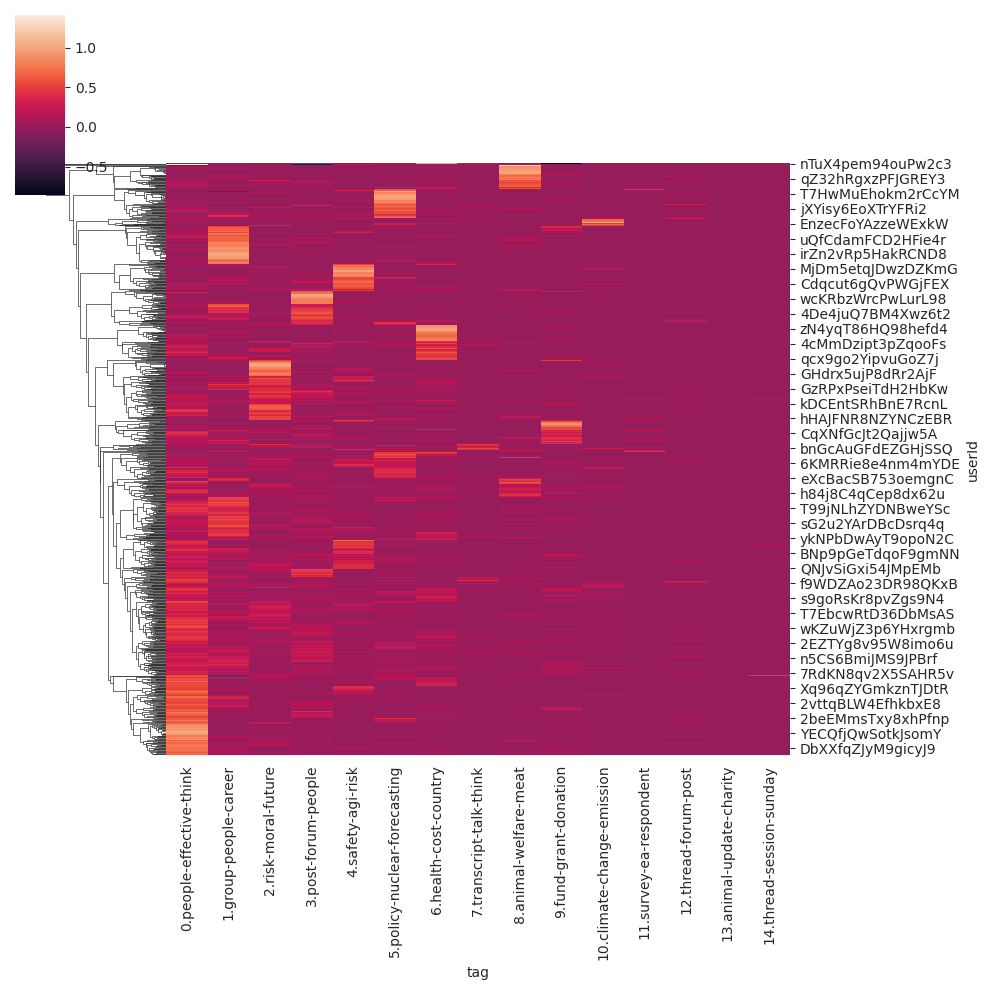

In [98]:
cmap = sns.clustermap(user_specificity_to_dv_clusts, col_cluster=False)

In [112]:
user_specificity_to_dv_clusts.index.name = None
user_specificity_to_dv_clusts.columns.name = None
hm_dict, user_levels, clust_levels = get_heatmap_json(user_specificity_to_dv_clusts.iloc[cmap.dendrogram_row.reordered_ind, :], col_names=['user', 'cluster', 'score'])

user_tag_matching_json = {
    'scores': hm_dict,
    'user_levels': user_levels,
    'usernames': list(users.username[user_levels]),
    'clust_levels': clust_levels
}

with open(outputp('data/user_clust_matching.json'), 'w') as f:
    json.dump(user_tag_matching_json, f)